In [ ]:
 import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from skimage import io, segmentation, color


# Load image
img = cv2.imread("/content/drive/MyDrive/CV Images/StarMan.jfif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

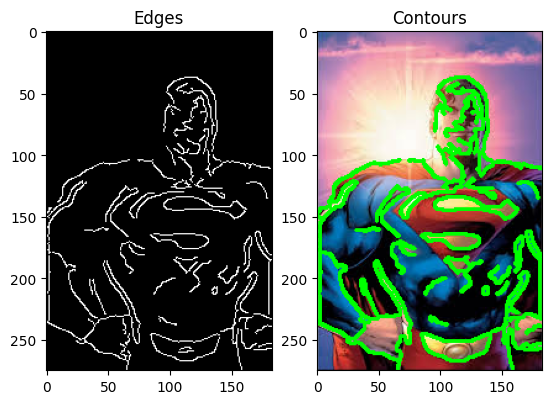

In [ ]:
# 1. Edge-based Segmentation

# Step 1: Reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 1.4)

# Step 2: Canny edge detection
edges = cv2.Canny(blur, 100, 200)

# Step 3: Morphological closing (optional)
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Step 4: Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title("Edges")
plt.subplot(122), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title("Contours")
plt.show()

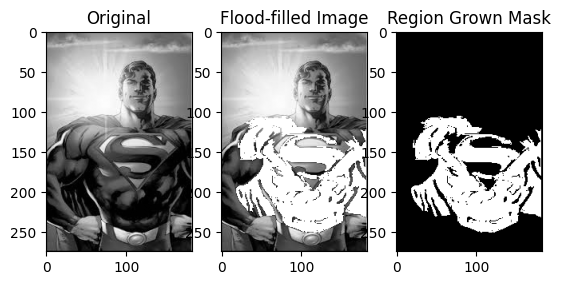

In [ ]:
#2. Region growing (seed based) Segmentation

# Copy for flood fill
flood_filled = gray.copy()

# Create mask (2 pixels larger than image required by floodFill)
h, w = gray.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Choose seed point (manually set here, can also be selected with mouse callback)
seed_point = (100, 150)  # (x, y)

# Flood fill parameters
lo_diff = 10   # Lower brightness/color difference
up_diff = 10   # Upper brightness/color difference
new_val = 255  # Fill value (white)

# Apply flood fill (region growing)
cv2.floodFill(flood_filled, mask, seed_point, new_val, loDiff=(lo_diff,), upDiff=(up_diff,))

# Binary mask of the grown region
region = cv2.inRange(flood_filled, new_val, new_val)

# Show results
plt.subplot(131), plt.imshow(gray, cmap='gray'), plt.title("Original")
plt.subplot(132), plt.imshow(flood_filled, cmap='gray'), plt.title("Flood-filled Image")
plt.subplot(133), plt.imshow(region, cmap='gray'), plt.title("Region Grown Mask")
plt.show()

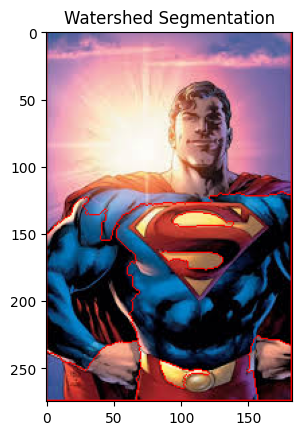

In [ ]:
#3. Watershed Segmentation
# Step 1: Threshold and morphological operations
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Distance transform → sure foreground
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.7*dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Step 2: Unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 3: Markers
_, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)
result = img.copy()
result[markers == -1] = [0, 0, 255]

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation")
plt.show()

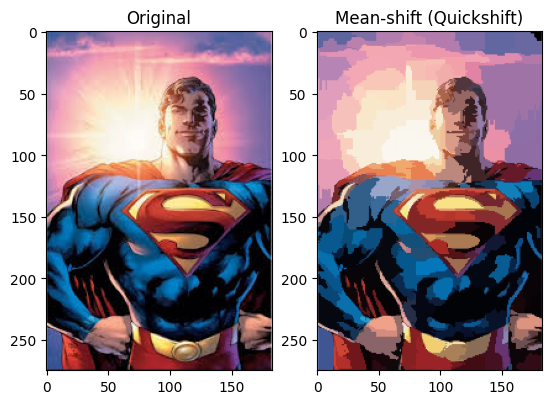

In [ ]:
#4. Mean-shift Segementation
# Load image
imag = io.imread("/content/drive/MyDrive/CV Images/StarMan.jfif")

# Step 2: Apply segmentation (Quickshift or SLIC)
segments = segmentation.quickshift(imag, kernel_size=3, max_dist=6, ratio=0.5)

# Step 3: Map labels to colors
seg_imag = color.label2rgb(segments, imag, kind='avg')

plt.subplot(121), plt.imshow(imag), plt.title("Original")
plt.subplot(122), plt.imshow(seg_imag), plt.title("Mean-shift (Quickshift)")
plt.show()

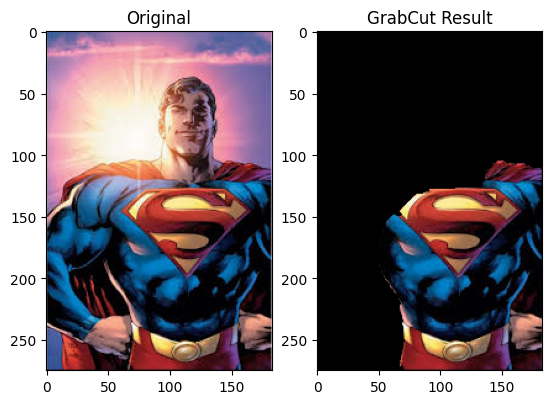

In [ ]:
#5. GrabCut Segmentation
mask = np.zeros(img.shape[:2], np.uint8)

# Step 1: Initial bounding box (x,y,w,h)
rect = (50, 50, 300, 300)

# Models
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Step 2: GrabCut
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Step 3: Extract foreground
output_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
result = img * output_mask[:, :, np.newaxis]

plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(122), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title("GrabCut Result")
plt.show()

In [ ]:
#Note: Write any 3 out of 5 in Observation